<a href="https://colab.research.google.com/github/raulbenitez/recommenders/blob/main/Intro_surprise_jester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install surpise libraries:

In [3]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 10.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618266 sha256=3441490cdf9982000bc579f18503551c7f6f92f661990818d362c01c7d0f3979
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


# Exercise 1: Data manipulation using surprise and Pandas

## Load jester database

And some exploration of the data

https://www.kaggle.com/raidevesh05/movie-ratings-dataset?select=movie_ratings.csv

In [4]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

data = Dataset.load_builtin('jester')

Dataset jester could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://eigentaste.berkeley.edu/dataset/archive/jester_dataset_2.zip...
Done! Dataset jester has been saved to /root/.surprise_data/jester


Access the ratings from the raw data:

In [5]:
raw_data = data.raw_ratings
print("Each entry has the columns: user_id, item_id,  rating and timestamp")
print(raw_data[0])
print(raw_data[1])
print(raw_data[2])
print("\n")

Each entry has the columns: user_id, item_id,  rating and timestamp
('1', '5', 0.219, None)
('1', '7', -9.281, None)
('1', '8', -9.281, None)




Mean rating of a user and mean rating of an item

Load as a pandas dataframe for convenience to manipulate data:

In [6]:
import pandas as pd
df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id', 'item_id', 'rating', 'timestamp'])
df.head(10)

,user_id,item_id,rating,timestamp
0,1,5,0.219,None
1,1,7,-9.281,None
2,1,8,-9.281,None
3,1,13,-6.781,None
4,1,15,0.875,None
5,1,16,-9.656,None
6,1,17,-9.031,None
7,1,18,-7.469,None
8,1,19,-8.719,None
9,1,20,-9.156,None


*Dimension* of the dataframe

In [7]:
df.shape

(1761439, 4)

What is the rating of the user with user_id = 1 of the joke with item_id = 5?

In [33]:
df.loc[(df["user_id"]=='1') & (df["item_id"]=='5')]

,user_id,item_id,rating,timestamp
0,1,5,0.219,None


In [34]:
print("Number of users in the database = " + str(df["user_id"].nunique()))
print("Number of items in the database = " + str(df["item_id"].nunique()))

Number of users in the database = 59132
Number of items in the database = 140


Number of jokes rated by user with user_id = 10:

In [35]:
df.loc[(df["user_id"]=='10')].shape[0]

104

Check the average rating score

In [36]:
print("Mean value of the rating column: " + str(df["rating"].mean())) 

Mean value of the rating column: 1.6186024017864769


Check which is the joke with larger average rating from the users:

In [37]:
dfmean = df.groupby(['item_id']).mean()
dfmean.sort_values(by=['rating'],ascending=False)

,rating
item_id,
53,3.714381
105,3.711223
89,3.606506
129,3.583496
35,3.560305
...,...
16,-1.587044
5,-1.756331
7,-1.809230


Remove items with less than 200 ratings and users that have rated less than 130 times:


In [38]:
min_item_ratings = 200
filter_items = df['item_id'].value_counts() > min_item_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 130
filter_users = df['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_small = df[(df['item_id'].isin(filter_items)) & (df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_small.shape))

The original data frame shape:	(1761439, 4)
The new data frame shape:	(1325, 4)


Check how many users and and items are there in the dataset:

In [39]:
print("Number of users in the reduced database = " + str(df_small["user_id"].nunique()))
print("Number of items in the reduced database = " + str(df_small["item_id"].nunique()))

Number of users in the reduced database = 10
Number of items in the reduced database = 133


In [40]:
df_small.head()

,user_id,item_id,rating,timestamp
1568,46,5,6.469,None
1569,46,7,-6.781,None
1570,46,8,8.625,None
1571,46,13,-8.062,None
1572,46,15,-4.156,None


Represent the distribution of number of users with a certain number of ratings:

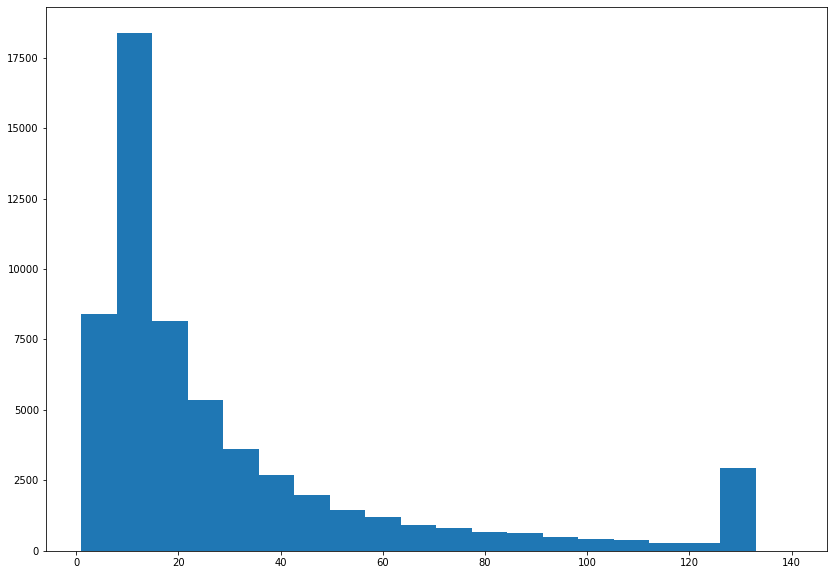

In [41]:
import matplotlib.pyplot as plt

v = df['user_id'].value_counts()

fig = plt.figure(figsize=(14,10))
plt.hist(v,20)
plt.show()

Identify a joke with a rating of 10

In [42]:
df_best = df.loc[df["rating"]==10]
df_best.head()

,user_id,item_id,rating,timestamp
755,17,17,10.0,None
758,17,20,10.0,None
766,17,35,10.0,None
771,17,49,10.0,None
2571,65,8,10.0,None


In [43]:
df_worst = df.loc[df["rating"]==-10]
df_best.head()

,user_id,item_id,rating,timestamp
755,17,17,10.0,None
758,17,20,10.0,None
766,17,35,10.0,None
771,17,49,10.0,None
2571,65,8,10.0,None


In [44]:
df_best['item_id'].unique().shape[0]

133

In [45]:
df['item_id'].unique().shape[0]

140

## Load data again from the reduced dataframe:

In [46]:
from surprise import Reader 
reader = Reader(rating_scale=(-10, 10))
data_small = Dataset.load_from_df(df_small[['user_id', 'item_id', 'rating']], reader)

# Exercise 2: Different ways to fit a recommender systems:

## a) Training with the whole reduced dataset

First, create a trainable set using the build_full_trainset() method from surpise libraries:

https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.DatasetAutoFolds.build_full_trainset



In [47]:
trainset = data_small.build_full_trainset()

Now fit a SVD model-based recommender algorithm:



In [48]:
from surprise import SVD

rec_svd = SVD()
rec_svd.fit(trainset)

Predict the ranking of a certain item item_id from a certain user user_id

In [51]:
raw_data = data_small.raw_ratings
print(raw_data[10])

('46', '44', 6.75, None)


In [52]:
user_id = str(46)  # raw user id (as in the ratings file). They are **strings**!
item_id = str(44)  # raw item id (as in the ratings file). They are **strings**!
true_ranking = 6.75

pred_svd = rec_svd.predict(user_id, item_id,r_ui=true_ranking,verbose=True)


user: 46         item: 44         r_ui = 6.75   est = 6.66   {'was_impossible': False}


Evaluate performance using training set:

In [55]:
from surprise import accuracy

testset = trainset.build_testset()
train_pred = rec_svd.test(testset)
accuracy.rmse(train_pred)
accuracy.mae(train_pred)
accuracy.mse(train_pred)

RMSE: 0.3484
MAE:  0.2473
MSE: 0.1214


0.12140956423800202

If we evaluate the performance with the training set we get a very low prediction error since the observations user to construct the model are also used to test it. This is not the normal procedure in machine learning. Instead, 
we split the dataset in training and test subsets. Let's see what happens when applying different propostions for the training and test subsets. 


## b) Split training and test with different proportions:

In [56]:
from surprise.model_selection import train_test_split

print('90% training 10% test:')
trainset, testset = train_test_split(data_small, test_size=.1)
rec_svd.fit(trainset)
train_pred = rec_svd.test(testset)
accuracy.rmse(train_pred)
accuracy.mae(train_pred)
accuracy.mse(train_pred)

print('75% training 25% test:')
trainset, testset = train_test_split(data_small, test_size=.25)
rec_svd.fit(trainset)
train_pred = rec_svd.test(testset)
accuracy.rmse(train_pred)
accuracy.mae(train_pred)
accuracy.mse(train_pred)

print('10% training 90% test:')
trainset, testset = train_test_split(data_small, test_size=.9)
rec_svd.fit(trainset)
train_pred = rec_svd.test(testset)
accuracy.rmse(train_pred)
accuracy.mae(train_pred)
accuracy.mse(train_pred)


90% training 10% test:
RMSE: 4.4168
MAE:  3.4801
MSE: 19.5085
75% training 25% test:
RMSE: 4.6739
MAE:  3.4899
MSE: 21.8457
10% training 90% test:
RMSE: 4.6962
MAE:  3.8949
MSE: 22.0539


22.053909514286172

It It is clear that the larger the training subset, the better the performance (i.e lower RMSE, MAE and MSE) when evaluated in the test subset. 

## c) Cross-validation:

Let's evaluate the performance using a 5-fold cross-validation (cv=5) procedure:


In [57]:
cross_validate(rec_svd, data_small, measures=['RMSE', 'MAE','MSE'], cv=5, verbose=True)

Evaluating RMSE, MAE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.2854  4.5110  4.1479  4.6241  4.5571  4.4251  0.1793  
MAE (testset)     3.3462  3.5381  3.2611  3.7900  3.5415  3.4954  0.1832  
MSE (testset)     18.3646 20.3490 17.2048 21.3823 20.7675 19.6136 1.5725  
Fit time          0.08    0.07    0.06    0.06    0.06    0.07    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'fit_time': (0.07626605033874512,
  0.06732511520385742,
  0.06304740905761719,
  0.06295037269592285,
  0.06471037864685059),
 'test_mae': array([3.34623069, 3.53810753, 3.26110474, 3.79001749, 3.54153608]),
 'test_mse': array([18.36458092, 20.34895529, 17.20475139, 21.38234586, 20.76750999]),
 'test_rmse': array([4.28539157, 4.51098163, 4.14786106, 4.62410487, 4.55713836]),
 'test_time': (0.0029582977294921875,
  0.002272367477416992,
  0.0021829605102539062,
  0.0021820068359375,
  0.002309560775756836)}

The average results of the cv procedure indicate that the performance is closer to the one obtained with a train-test split of the 90% - 10% 

# Explore different parameters of the SVD recommender algorithm:

https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD


Compare biased SVD versus unbiased SVD:


In [95]:
rec_svd_unbiased = SVD(biased = 'false')
cross_validate(rec_svd_unbiased, data_small, measures=['RMSE', 'MAE','MSE'], cv=5, verbose=True)

Evaluating RMSE, MAE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.3226  4.2460  4.2779  4.8780  4.3656  4.4180  0.2335  
MAE (testset)     3.3504  3.4220  3.4320  3.7910  3.3948  3.4781  0.1590  
MSE (testset)     18.6849 18.0286 18.3003 23.7951 19.0581 19.5734 2.1394  
Fit time          0.07    0.06    0.06    0.06    0.06    0.06    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'fit_time': (0.07158851623535156,
  0.060149431228637695,
  0.0580744743347168,
  0.06408882141113281,
  0.05853152275085449),
 'test_mae': array([3.35042352, 3.42202714, 3.4320174 , 3.79097535, 3.39483064]),
 'test_mse': array([18.68489237, 18.02858057, 18.30030867, 23.7950596 , 19.05806687]),
 'test_rmse': array([4.3226025 , 4.2460076 , 4.27788601, 4.878018  , 4.36555459]),
 'test_time': (0.0029599666595458984,
  0.001783132553100586,
  0.0017902851104736328,
  0.00185394287109375,
  0.0017931461334228516)}

The unbiased version is slightly better than the default biased one. 

# Improve performance using grid search CV:


https://surprise.readthedocs.io/en/stable/getting_started.html#tune-algorithm-parameters-with-gridsearchcv

In [96]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV

param_grid = {'biased': ['true', 'false']}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae','mse'], cv=5)

gs.fit(data_small)

# best RMSE score
print(gs.best_score['rmse'])
print(gs.best_score['mae'])
print(gs.best_score['mse'])


# combination of parameters that gave the best RMSE score
print('Best SVD parameters:')
print(gs.best_params['rmse'])

4.433704681618332
3.483266044438421
19.684983126754226
Best SVD parameters:
{'biased': 'true'}
